In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#### Importing inorder to ignore all warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

#### loading the dataset

In [4]:
# importing the dataset
df_train = pd.read_csv('/content/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('/content/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [5]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
print(df_train.shape, df_test.shape, df_val.shape)

(16000, 2) (2000, 2) (2000, 2)


### now lets do some EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'


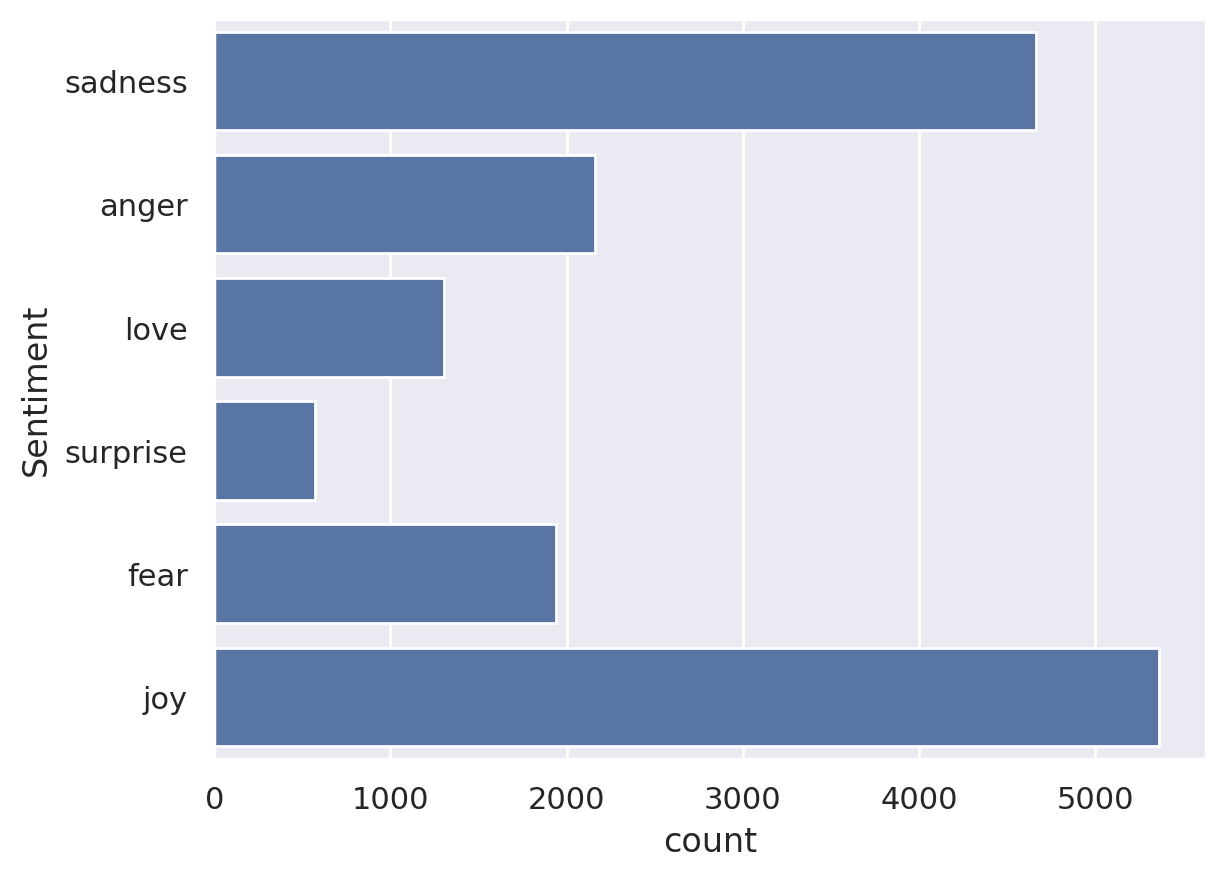

In [8]:
sns.countplot(df_train.Sentiment)
plt.show()

In [9]:
df_train['Length'] = df_train.Input.apply(lambda x:len(x))

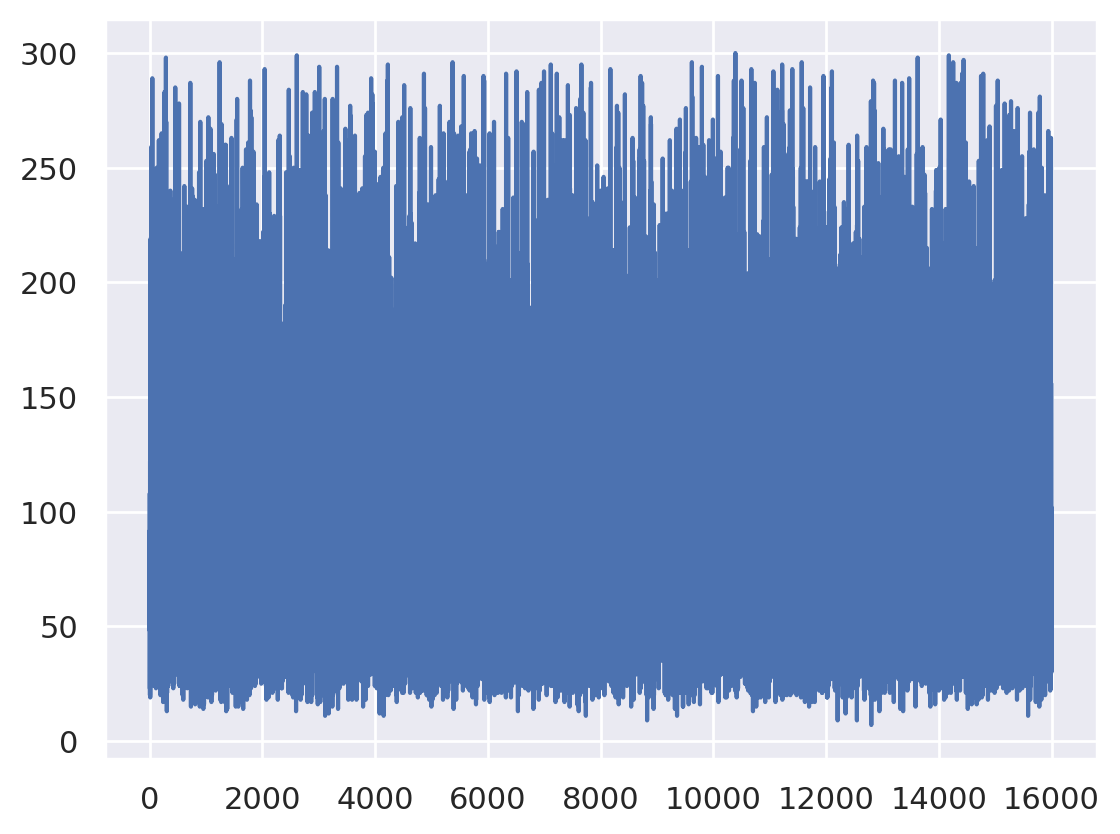

In [10]:
plt.plot(df_train.Length)
plt.show()

In [11]:
df_train.Length.max() # max length of our text body

300

### Now lets do some text preprocessing

In [12]:
# i'm using a text preprocessing library for this
!pip install text_hammer
import text_hammer as th

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.13.3
    Uninstalling beautifulsoup4-4.13.3:
      Successfully uninstalled beautifulsoup4-4.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.54 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


### here i am using progress_apply inorder to plot a nice looking bar_plot

In [13]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
# here we can remove stop-words but in this case removing not, and ,can change the meaning of context

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 544 µs, sys: 0 ns, total: 544 µs
Wall time: 551 µs


In [14]:
df_cleaned_train = text_preprocessing(df_train, 'Input')

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [15]:
df_cleaned_train.head()

,Input,Sentiment,Length
0,I do not feel humiliate,sadness,23
1,I can go from feel so hopeless to so damned ho...,sadness,108
2,I m grab a minute to post I feel greedy wrong,anger,48
3,I am ever feel nostalgic about the fireplace I...,love,92
4,I am feel grouchy,anger,20


#### Converting the text output  into integer (label encoding )

In [16]:
df_cleaned_train['Sentiment']=df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment']=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment']=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

Encoding the output values

#### Using The tokenizer Class to convert the sentences into word vectors


In [18]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

In [19]:
num_words = 10000 # this means 10000 unique words can be taken
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)


In [20]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we are taking only 10000 words in our model

13891

In [21]:
from keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input']) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [22]:
from keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)


In [23]:
print(X_train_pad.shape, X_val_pad.shape)

(16000, 300) (2000, 300)


### now we have our X_data and y_data is ready now lets create a weight matrix
### For creating weight matrix we are using gensim word2vec
#### here we are going to use glove-word2vec since we dont wanna loose the context meaning
#### lets say ( 'love', 'affection','like') these  words will have almost same meaning if we will use glove-word2vec

In [24]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension
# more dimension means more deep meaning of words but it may take longer time to download

[==================================================] 100.0% 128.1/128.1MB downloaded


In [25]:
glove_gensim['cat'].shape[0]

100

Creating a word2Vec weight matrix

In [27]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero
        if word in glove_gensim.key_to_index: # Changed line to check in key_to_index
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [28]:
gensim_weight_matrix.shape

(10000, 100)

Designing a LSTM model with GPU support

In [37]:
!pip install --upgrade keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Dropout



In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU
from tensorflow.keras.layers import Dropout

#### Stacked Bidirectional LSTM with GPU(CUDNN)

In [44]:
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=EMBEDDING_DIM,
                    input_length=X_train_pad.shape[1],
                    weights=[gensim_weight_matrix],
                    trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))  # Gunakan LSTM
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(200, return_sequences=True)))   # Tambahkan GRU
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [47]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 5, batch_size = 120, validation_data=(X_val_pad, y_val),verbose = 1, callbacks= [es, mc]  )


Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6577 - loss: 0.9347
Epoch 1: val_accuracy improved from 0.54350 to 0.79200, saving model to ./model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.6579 - loss: 0.9342 - val_accuracy: 0.7920 - val_loss: 0.6075
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7543 - loss: 0.6710
Epoch 2: val_accuracy improved from 0.79200 to 0.84350, saving model to ./model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.7544 - loss: 0.6707 - val_accuracy: 0.8435 - val_loss: 0.4584
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8096 - loss: 0.5138
Epoch 3: val_accuracy improved from 0.84350 to 0.87200, saving model to ./model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.8096 - loss: 0.5137 - val_accuracy: 0.8720 - val_loss: 0.3708
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8458 - loss: 0.4185
Epoch 4: val_accuracy improved from 0.87200 to 0.87900, saving model to ./model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.8458 - loss: 0.4185 - val_accuracy: 0.8790 - val_loss: 0.3308
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8666 - loss: 0.3583
Epoch 5: val_accuracy improved from 0.87900 to 0.89000, saving model to ./model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.8666 - loss: 0.3583 - val_accuracy: 0.8900 - val_loss: 0.2995


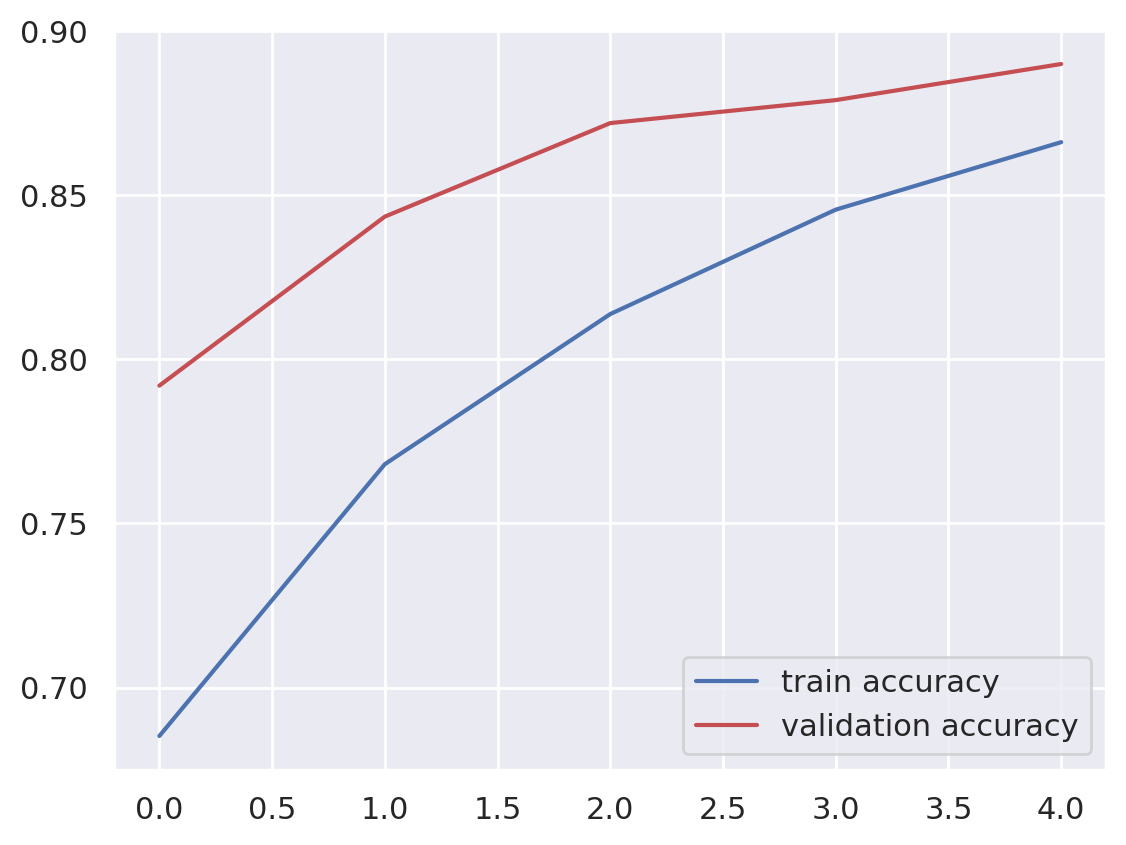

In [48]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

#### now lets test on some real data

In [49]:
model.evaluate(X_test_pad, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8853 - loss: 0.3014


[0.2947351634502411, 0.8880000114440918]

In [50]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


In [51]:
y_true = np.argmax(y_test, axis = 1)


In [52]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       742
           1       0.84      0.92      0.87       251
           2       0.73      0.81      0.77       143
           3       0.93      0.94      0.93       576
           4       0.89      0.82      0.86       243
           5       0.55      0.80      0.65        45

    accuracy                           0.89      2000
   macro avg       0.81      0.86      0.83      2000
weighted avg       0.89      0.89      0.89      2000



# checking our own Sentences

In [53]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key

In [54]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=300,padding='post')
    ans=get_key(model.predict_classes(sentence_padded))
    print("The emotion predicted is",ans)

In [ ]:
predict(str(input('Enter a sentence : ')))
